<a href="https://colab.research.google.com/github/KD1994/EIP-Sessions/blob/master/Week-5/PersonAttrubutes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Data from Drive

In [0]:
# mount gdrive and unzip data
from google.colab import drive
drive.mount('/content/gdrive')
!unzip -q "/content/gdrive/My Drive/hvc_data.zip"
# look for `hvc_annotations.csv` file and `resized` dir
%ls 

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
replace resized/9733.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
gdrive/  hvc_annotations.csv  hvc_best_model.h5  resized/  sample_data/


# Import Packages

In [0]:
%tensorflow_version 1.x
%matplotlib inline

import cv2
import json
import time
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas as pd
import os
from functools import partial
from pathlib import Path 
from tqdm import tqdm

from google.colab.patches import cv2_imshow

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

import keras
from keras import backend as K
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils, plot_model
from keras.layers.convolutional import Convolution2D, SeparableConv2D
from keras.layers.pooling import GlobalAveragePooling2D, AveragePooling2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout, Input
from keras.regularizers import l1, l2
from keras.optimizers import Adam, SGD
from keras.models import load_model, Model, Sequential
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler, Callback
from keras.utils import plot_model
from keras.applications import InceptionV3

# Load Data

In [0]:
# load annotations
df = pd.read_csv("hvc_annotations.csv")
del df["filename"] # remove unwanted column
df.head()

,gender,imagequality,age,weight,carryingbag,footwear,emotion,bodypose,image_path
0,male,Average,35-45,normal-healthy,Grocery/Home/Plastic Bag,Normal,Neutral,Front-Frontish,resized/1.jpg
1,female,Average,35-45,over-weight,None,Normal,Angry/Serious,Front-Frontish,resized/2.jpg
2,male,Good,45-55,normal-healthy,Grocery/Home/Plastic Bag,CantSee,Neutral,Front-Frontish,resized/3.jpg
3,male,Good,45-55,normal-healthy,Daily/Office/Work Bag,Normal,Neutral,Front-Frontish,resized/4.jpg
4,female,Good,35-45,slightly-overweight,None,CantSee,Neutral,Front-Frontish,resized/5.jpg


# Preprocessing

In [0]:
# one hot encoding of labels

one_hot_df = pd.concat([
    df[["image_path"]],
    pd.get_dummies(df.gender, prefix="gender"),
    pd.get_dummies(df.imagequality, prefix="imagequality"),
    pd.get_dummies(df.age, prefix="age"),
    pd.get_dummies(df.weight, prefix="weight"),
    pd.get_dummies(df.carryingbag, prefix="carryingbag"),
    pd.get_dummies(df.footwear, prefix="footwear"),
    pd.get_dummies(df.emotion, prefix="emotion"),
    pd.get_dummies(df.bodypose, prefix="bodypose"),
], axis = 1)

one_hot_df.head().T

,0,1,2,3,4
image_path,resized/1.jpg,resized/2.jpg,resized/3.jpg,resized/4.jpg,resized/5.jpg
gender_female,0,1,0,0,1
gender_male,1,0,1,1,0
imagequality_Average,1,1,0,0,0
imagequality_Bad,0,0,0,0,0
imagequality_Good,0,0,1,1,1
age_15-25,0,0,0,0,0
age_25-35,0,0,0,0,0
age_35-45,1,1,0,0,1
age_45-55,0,0,1,1,0


In [0]:
train_df, val_df = train_test_split(one_hot_df, test_size=0.15, random_state=42)
train_df.shape, val_df.shape

((11537, 28), (2036, 28))

In [0]:
train_df.head()

,image_path,gender_female,gender_male,imagequality_Average,imagequality_Bad,imagequality_Good,age_15-25,age_25-35,age_35-45,age_45-55,age_55+,weight_normal-healthy,weight_over-weight,weight_slightly-overweight,weight_underweight,carryingbag_Daily/Office/Work Bag,carryingbag_Grocery/Home/Plastic Bag,carryingbag_None,footwear_CantSee,footwear_Fancy,footwear_Normal,emotion_Angry/Serious,emotion_Happy,emotion_Neutral,emotion_Sad,bodypose_Back,bodypose_Front-Frontish,bodypose_Side
10416,resized/10418.jpg,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0
3495,resized/3496.jpg,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,1,0,0
6950,resized/6951.jpg,1,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1
5035,resized/5036.jpg,1,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,1,0
4410,resized/4411.jpg,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,1


# Data Generator

In [0]:
# Label columns per attribute
_gender_cols_ = [col for col in one_hot_df.columns if col.startswith("gender")]
_imagequality_cols_ = [col for col in one_hot_df.columns if col.startswith("imagequality")]
_age_cols_ = [col for col in one_hot_df.columns if col.startswith("age")]
_weight_cols_ = [col for col in one_hot_df.columns if col.startswith("weight")]
_carryingbag_cols_ = [col for col in one_hot_df.columns if col.startswith("carryingbag")]
_footwear_cols_ = [col for col in one_hot_df.columns if col.startswith("footwear")]
_emotion_cols_ = [col for col in one_hot_df.columns if col.startswith("emotion")]
_bodypose_cols_ = [col for col in one_hot_df.columns if col.startswith("bodypose")]

class PersonDataGenerator(keras.utils.Sequence):
    """Ground truth data generator"""
    
    def __init__(self, df, batch_size=32, shuffle=True, transform=None):
        self.df = df
        self.batch_size=batch_size
        self.shuffle = shuffle
        self.transform = transform
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(self.df.shape[0] / self.batch_size))

    def __getitem__(self, index):
        """fetch batched images and targets"""
        batch_slice = slice(index * self.batch_size, (index + 1) * self.batch_size)
        items = self.df.iloc[batch_slice]
        image = np.stack([cv2.imread(item["image_path"]) for _, item in items.iterrows()])
        # image_mean = np.mean(image, axis=(0,1,2))
        # image_std = np.std(image, axis=(0,1,2))
        # normalize = lambda x: ((x - image_mean) / image_std).astype('float32')
        # image = normalize(image)

        target = {
            "gender_output": items[_gender_cols_].values,
            "image_quality_output": items[_imagequality_cols_].values,
            "age_output": items[_age_cols_].values,
            "weight_output": items[_weight_cols_].values,
            "bag_output": items[_carryingbag_cols_].values,
            "pose_output": items[_bodypose_cols_].values,
            "footwear_output": items[_footwear_cols_].values,
            "emotion_output": items[_emotion_cols_].values,
        }

        if self.transform:
            image = self.transform.flow(image, shuffle=False).next()

        return image, target

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        if self.shuffle == True:
            self.df = self.df.sample(frac=1).reset_index(drop=True)


In [0]:
# def cutout(mask_size):
#     def eraser(input_img):
#         mask_value = input_img.mean()

#         h, w, _ = input_img.shape
#         top = np.random.randint(0 - mask_size // 2, h - mask_size)
#         left = np.random.randint(0 - mask_size // 2, w - mask_size)
#         bottom = top + mask_size
#         right = left + mask_size
#         if top < 0:
#             top = 0
#         if left < 0:
#             left = 0
#         input_img[top:bottom, left:right, :].fill(mask_value)

#         return input_img
#     return eraser

# transforms = ImageDataGenerator(rotation_range=10,
#                                 # width_shift_range=0.1,
#                                 # height_shift_range=0.1,
#                                 horizontal_flip=True)
#                                 # preprocessing_function=cutout(mask_size=200//4))

# create train and validation data generators
train_gen = PersonDataGenerator(train_df, batch_size=32)

valid_gen = PersonDataGenerator(val_df, batch_size=64, shuffle=False)

In [0]:
# get number of output units from data
images, targets = next(iter(train_gen))
num_units = { k.split("_output")[0]:v.shape[1] for k, v in targets.items()}
num_units

{'age': 5,
 'bag': 3,
 'emotion': 4,
 'footwear': 3,
 'gender': 2,
 'image_quality': 3,
 'pose': 3,
 'weight': 4}

- - - - - - - - - - - - - - - - 
Image: 4, Shape: (224, 224, 3)
- - - - - - - - - - - - - - - - 


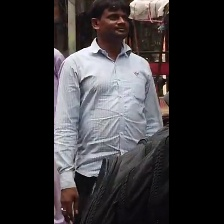

In [0]:
# Show a random image from the Batch
no = np.random.randint(0, images.shape[0])
print('- - '*8)
print('Image: {}, Shape: {}'.format(no, images[no].shape))
print('- - '*8)
cv2_imshow(images[no])
print('- - '*8)
print(_gender_cols_[np.argmax(targets['gender_output'][no])].split('_'))
print(_imagequality_cols_[np.argmax(targets['image_quality_output'][no])].split('_'))
print(_age_cols_[np.argmax(targets['age_output'][no])].split('_'))
print(_weight_cols_[np.argmax(targets['weight_output'][no])].split('_'))
print(_carryingbag_cols_[np.argmax(targets['bag_output'][no])].split('_'))
print(_footwear_cols_[np.argmax(targets['pose_output'][no])].split('_'))
print(_emotion_cols_[np.argmax(targets['footwear_output'][no])].split('_'))
print(_bodypose_cols_[np.argmax(targets['emotion_output'][no])].split('_'))

In [0]:
print(_gender_cols_[np.argmax(targets['gender_output'][no])].split('_'))
print(_imagequality_cols_[np.argmax(targets['image_quality_output'][no])].split('_'))
print(_age_cols_[np.argmax(targets['age_output'][no])].split('_'))
print(_weight_cols_[np.argmax(targets['weight_output'][no])].split('_'))
print(_carryingbag_cols_[np.argmax(targets['bag_output'][no])].split('_'))
print(_footwear_cols_[np.argmax(targets['pose_output'][no])].split('_'))
print(_emotion_cols_[np.argmax(targets['footwear_output'][no])].split('_'))
print(_bodypose_cols_[np.argmax(targets['emotion_output'][no])].split('_'))

['gender', 'male']
['imagequality', 'Good']
['age', '35-45']
['weight', 'normal-healthy']
['carryingbag', 'Daily/Office/Work Bag']
['footwear', 'Fancy']
['emotion', 'Angry/Serious']
['bodypose', 'Side']


# Plot Function

In [0]:
def plot_model_history(model_history):
    fig, ax = plt.subplots(8, 2,figsize=(15, 30))

    val_acc_list = ['val_gender_output_acc', 'val_image_quality_output_acc',
                    'val_age_output_acc', 'val_weight_output_acc',
                    'val_bag_output_acc', 'val_footwear_output_acc',
                    'val_pose_output_acc', 'val_emotion_output_acc']
    val_loss_list= ['val_gender_output_loss', 'val_image_quality_output_loss',
                    'val_age_output_loss', 'val_weight_output_loss',
                    'val_bag_output_loss', 'val_footwear_output_loss',
                    'val_pose_output_loss', 'val_emotion_output_loss']
    train_acc_list = ['gender_output_acc', 'image_quality_output_acc',
                    'age_output_acc', 'weight_output_acc',
                    'bag_output_acc', 'footwear_output_acc',
                    'pose_output_acc', 'emotion_output_acc']
    train_loss_list = ['gender_output_loss', 'image_quality_output_loss', 
                    'age_output_loss', 'weight_output_loss',
                    'bag_output_loss', 'footwear_output_loss',
                    'pose_output_loss', 'emotion_output_loss']

    for i in range(8):
        for j in range(2):
            if j == 0:
                ax[i, j].plot(range(1,len(model_history.history[train_acc_list[i]])+1),model_history.history[train_acc_list[i]])
                ax[i, j].plot(range(1,len(model_history.history[val_acc_list[i]])+1),model_history.history[val_acc_list[i]])
                title = train_acc_list[i].split('_')[0] + ' Accuracy'
                ax[i, j].set_ylabel('Accuracy')
                ax[i, j].legend([train_acc_list[i], val_acc_list[i]], loc='best')
            else:
                ax[i, j].plot(range(1,len(model_history.history[train_loss_list[i]])+1),model_history.history[train_loss_list[i]])
                ax[i, j].plot(range(1,len(model_history.history[val_loss_list[i]])+1),model_history.history[val_loss_list[i]])
                title = val_acc_list[i].split('_')[1] + ' Loss'
                ax[i, j].set_ylabel('Loss')
                ax[i, j].legend([train_loss_list[i], val_loss_list[i]], loc='best')
            ax[i, j].set_title(title)
            ax[i, j].set_xlabel('Epoch')
            ax[i, j].grid(True)  
    plt.tight_layout()
    plt.show()    

# InceptionV3

In [0]:
backbone = InceptionV3(
       include_top=False, 
       weights=None,
       input_tensor=Input(shape=(200, 200, 3)),
    )

neck = backbone.output
neck = Flatten(name="flatten")(neck)
neck = Dense(512, activation="relu")(neck)

def build_tower(in_layer):
    neck = Dense(128, activation="relu")(in_layer)
    return neck

def build_head(name, in_layer):
    return Dense(
        num_units[name], activation="softmax", name=f"{name}_output"
    )(in_layer)

# heads
gender = build_head("gender", build_tower(neck))
image_quality = build_head("image_quality", build_tower(neck))
age = build_head("age", build_tower(neck))
weight = build_head("weight", build_tower(neck))
bag = build_head("bag", build_tower(neck))
footwear = build_head("footwear", build_tower(neck))
emotion = build_head("emotion", build_tower(neck))
pose = build_head("pose", build_tower(neck))

model = Model(inputs=backbone.input, 
              outputs=[gender, image_quality, age, weight,
                       bag, footwear, pose, emotion],)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 200, 200, 3)  0                                            
__________________________________________________________________________________________________
conv2d_74 (Conv2D)              (None, 99, 99, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_74 (BatchNo (None, 99, 99, 32)   96          conv2d_74[0][0]                  
__________________________________________________________________________________________________
activation_73 (Activation)      (None, 99, 99, 32)   0           batch_normalization_74[0][0]     
____________________________________________________________________________________________

## epoch **(1 to 25)**

Directory Created!
Epoch 1/25
360/360 [==============================] - 107s 298ms/step - loss: 2.4459 - gender_output_loss: 0.6523 - image_quality_output_loss: 0.9791 - age_output_loss: 1.4190 - weight_output_loss: 0.9780 - bag_output_loss: 0.9115 - footwear_output_loss: 0.9775 - pose_output_loss: 0.9188 - emotion_output_loss: 0.9211 - gender_output_acc: 0.6171 - image_quality_output_acc: 0.5516 - age_output_acc: 0.3928 - weight_output_acc: 0.6373 - bag_output_acc: 0.5626 - footwear_output_acc: 0.5307 - pose_output_acc: 0.6172 - emotion_output_acc: 0.7083 - val_loss: 2.4096 - val_gender_output_loss: 0.6377 - val_image_quality_output_loss: 0.9867 - val_age_output_loss: 1.3942 - val_weight_output_loss: 0.9929 - val_bag_output_loss: 0.9030 - val_footwear_output_loss: 0.9563 - val_pose_output_loss: 0.8972 - val_emotion_output_loss: 0.8699 - val_gender_output_acc: 0.6245 - val_image_quality_output_acc: 0.5575 - val_age_output_acc: 0.3997 - val_weight_output_acc: 0.6240 - val_bag_output_ac

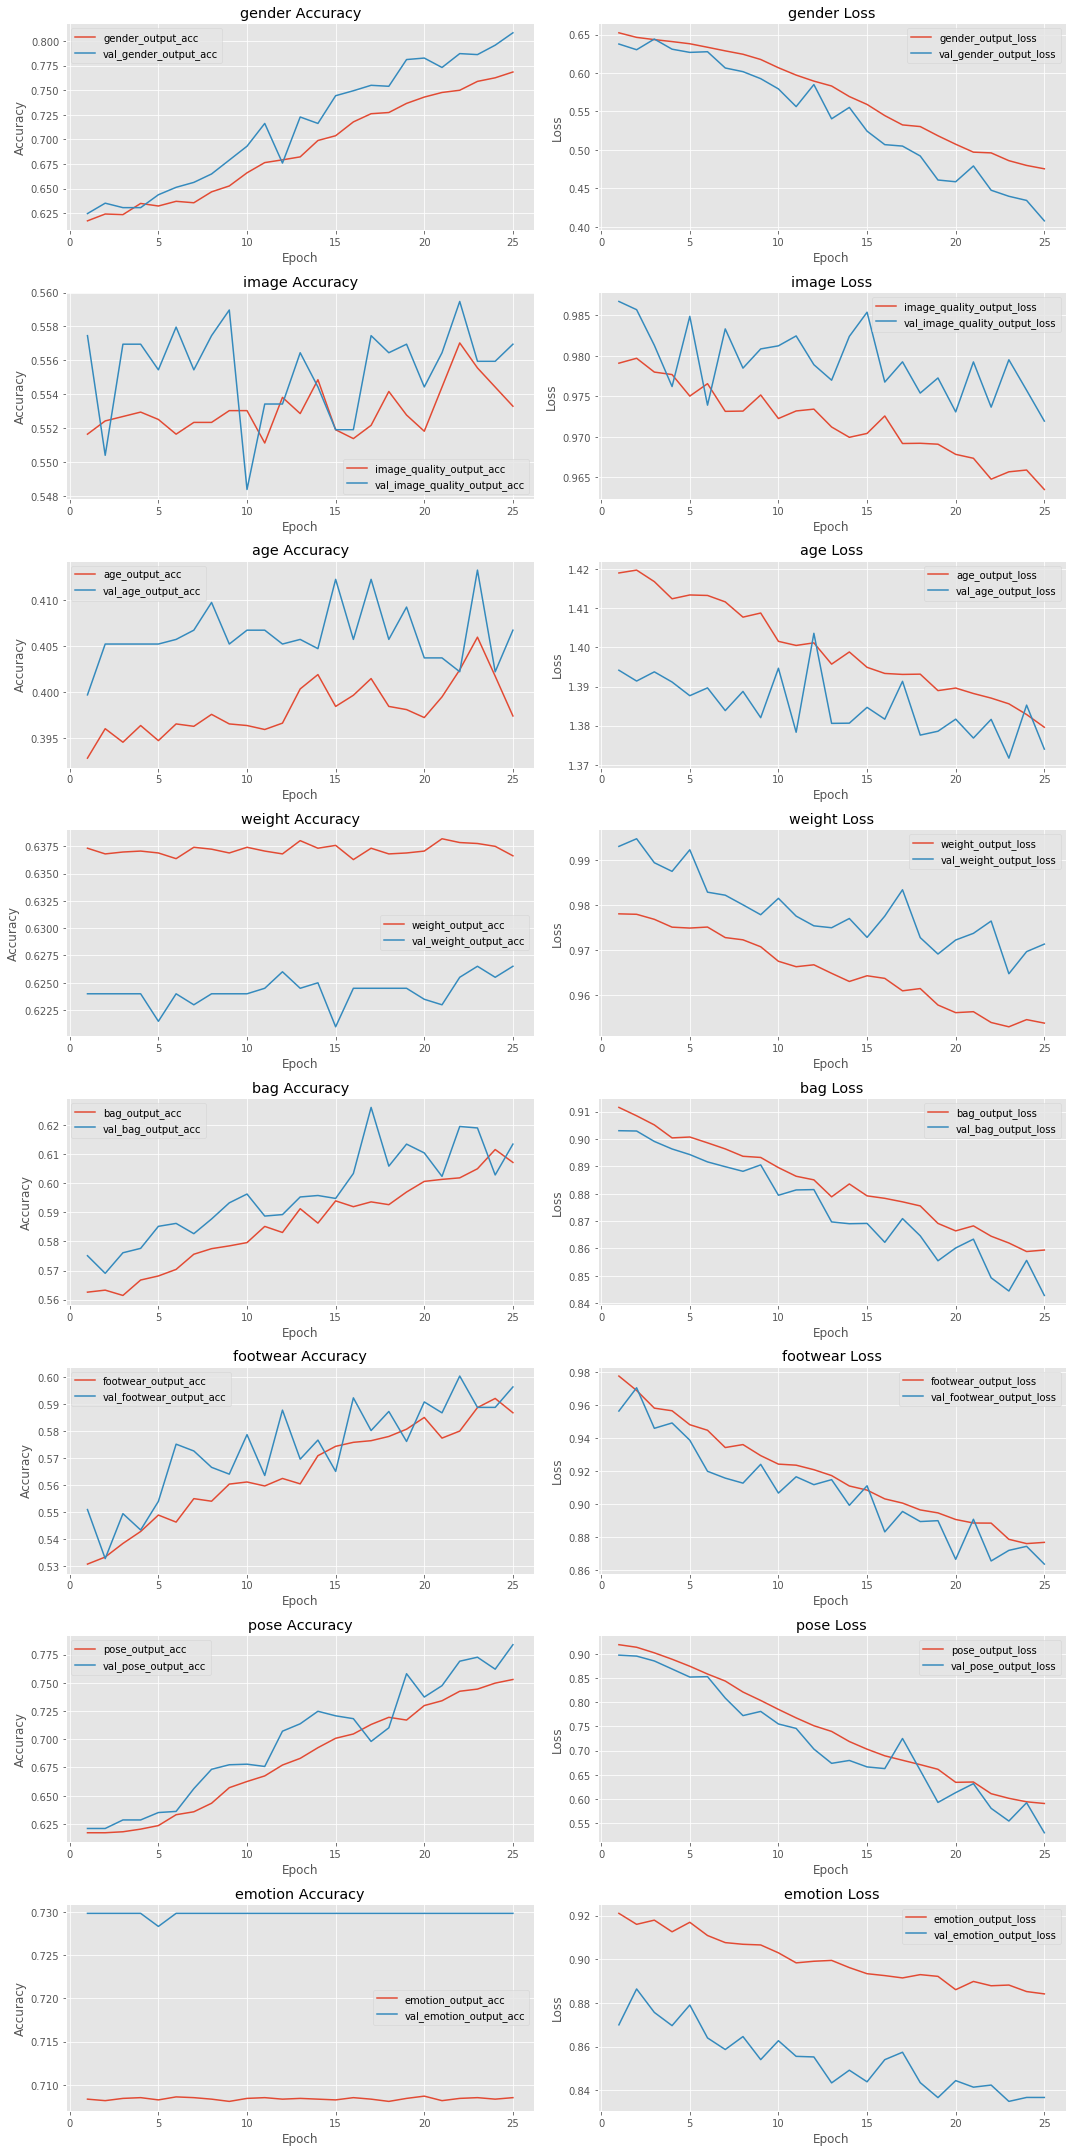

In [0]:
train_n_test(model)

## epoch **(25 to 50)**

[INFO] loading model /content/gdrive/My Drive/saved_model/epoch_25.h5 ...
[INFO] old learning rate: 0.003000000026077032
[INFO] start from the learning rate: 0.003
Epoch 1/25
360/360 [==============================] - 105s 293ms/step - loss: 2.0272 - gender_output_loss: 0.4609 - image_quality_output_loss: 0.9639 - age_output_loss: 1.3828 - weight_output_loss: 0.9504 - bag_output_loss: 0.8563 - footwear_output_loss: 0.8736 - pose_output_loss: 0.5883 - emotion_output_loss: 0.8876 - gender_output_acc: 0.7767 - image_quality_output_acc: 0.5531 - age_output_acc: 0.4041 - weight_output_acc: 0.6386 - bag_output_acc: 0.6110 - footwear_output_acc: 0.5960 - pose_output_acc: 0.7535 - emotion_output_acc: 0.7084 - val_loss: 2.1328 - val_gender_output_loss: 0.4993 - val_image_quality_output_loss: 0.9779 - val_age_output_loss: 1.3773 - val_weight_output_loss: 0.9789 - val_bag_output_loss: 0.8739 - val_footwear_output_loss: 0.9076 - val_pose_output_loss: 0.6754 - val_emotion_output_loss: 0.8398 - val_

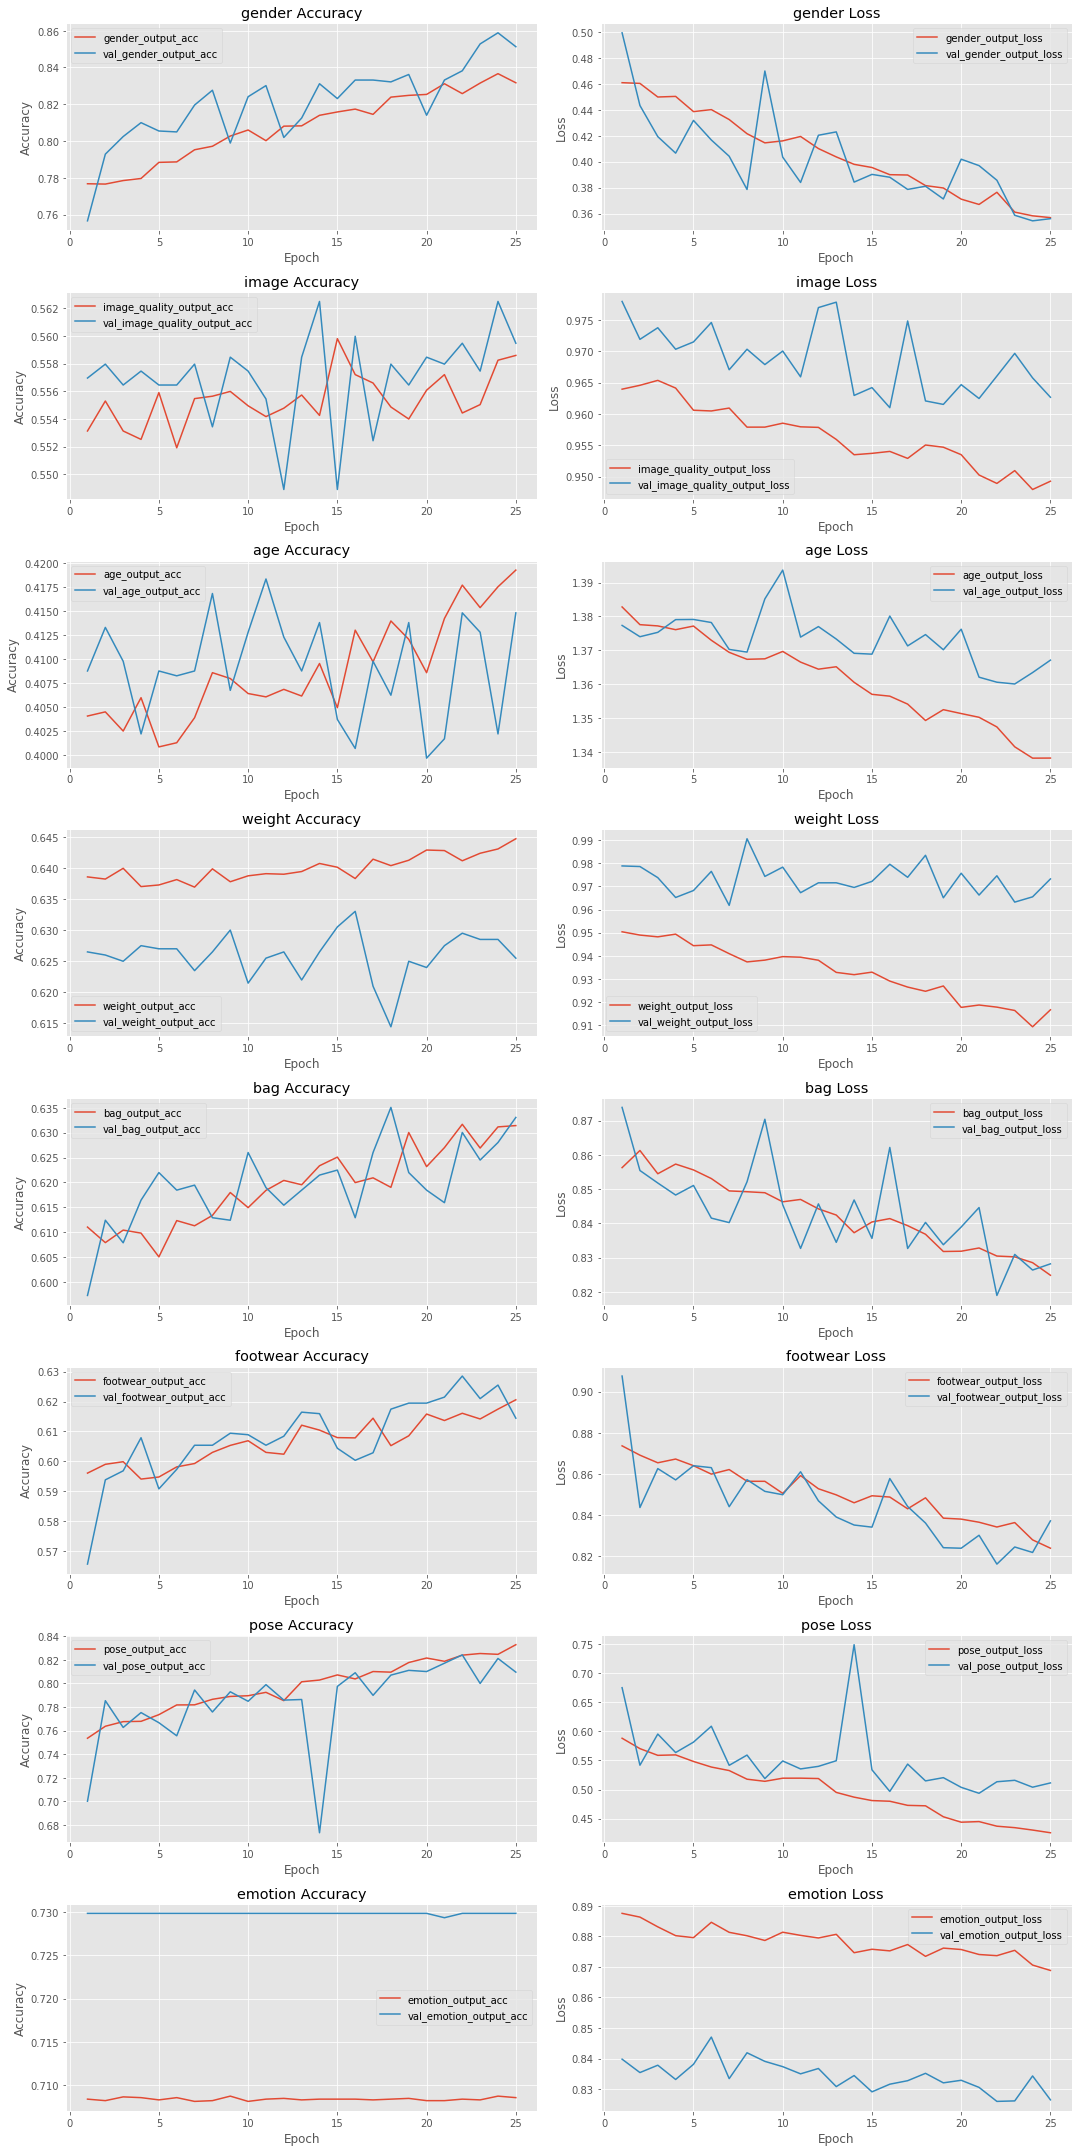

In [0]:
train_n_test(model, MODEL_SAVE_PATH=MODEL_PATH, saved_model=True)

## epoch **(50 to 75)**

[INFO] loading model /content/gdrive/My Drive/saved_model/epoch_50.h5 ...
[INFO] old learning rate: 0.003000000026077032
[INFO] start from the learning rate: 0.001
Epoch 1/25
360/360 [==============================] - 109s 304ms/step - loss: 1.7461 - gender_output_loss: 0.3341 - image_quality_output_loss: 0.9460 - age_output_loss: 1.3343 - weight_output_loss: 0.8983 - bag_output_loss: 0.8202 - footwear_output_loss: 0.8193 - pose_output_loss: 0.3876 - emotion_output_loss: 0.8679 - gender_output_acc: 0.8464 - image_quality_output_acc: 0.5566 - age_output_acc: 0.4199 - weight_output_acc: 0.6458 - bag_output_acc: 0.6377 - footwear_output_acc: 0.6265 - pose_output_acc: 0.8477 - emotion_output_acc: 0.7080 - val_loss: 1.8641 - val_gender_output_loss: 0.3470 - val_image_quality_output_loss: 0.9670 - val_age_output_loss: 1.3581 - val_weight_output_loss: 0.9616 - val_bag_output_loss: 0.8210 - val_footwear_output_loss: 0.8140 - val_pose_output_loss: 0.4900 - val_emotion_output_loss: 0.8280 - val_

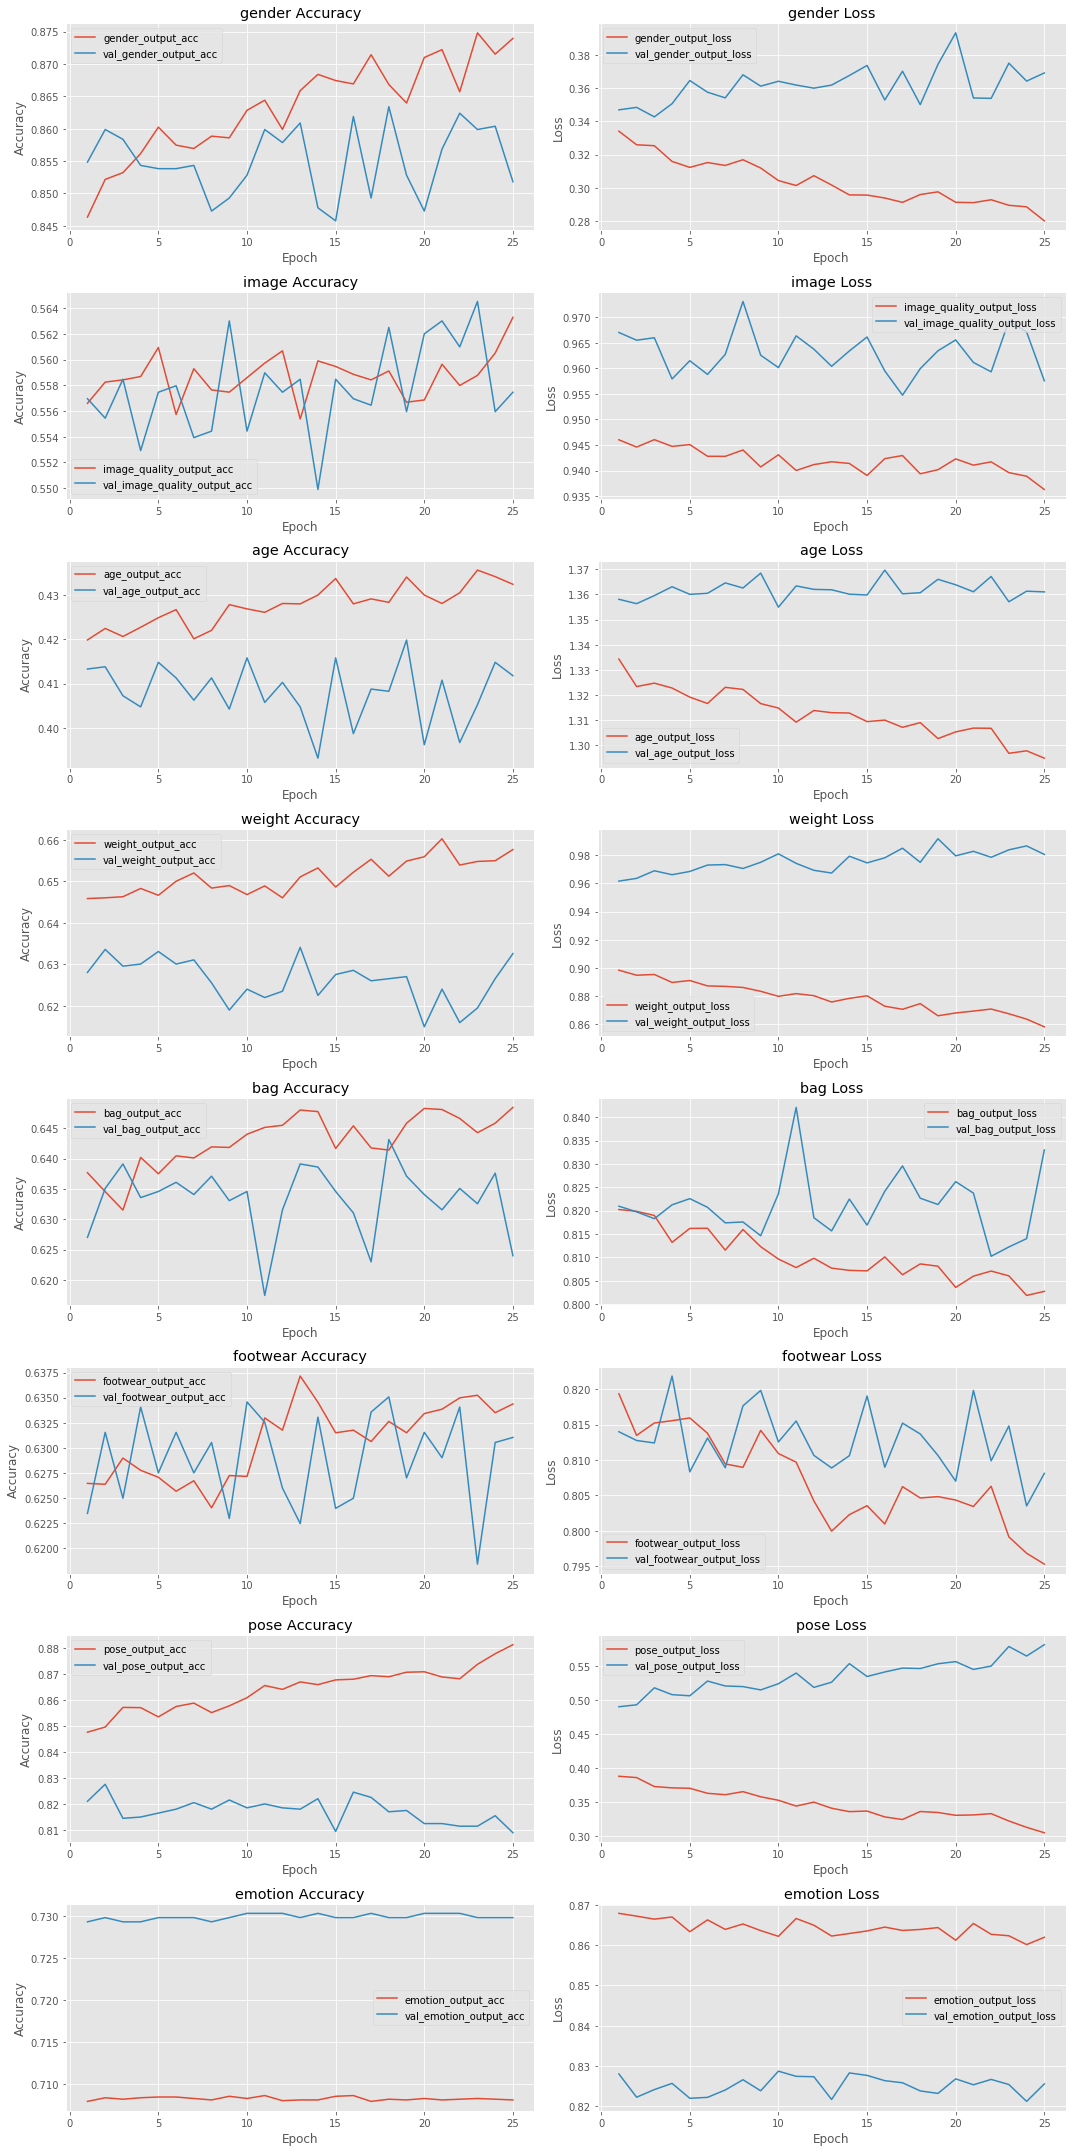

In [0]:
train_n_test(model, lr=1e-3, MODEL_SAVE_PATH=MODEL_PATH, saved_model=True)

## epoch **(75 to 100)**

[INFO] loading model /content/gdrive/My Drive/saved_model/epoch_75.h5 ...
[INFO] old learning rate: 0.0010000000474974513
[INFO] start from the learning rate: 0.0001
Epoch 1/25
360/360 [==============================] - 114s 315ms/step - loss: 1.5930 - gender_output_loss: 0.2673 - image_quality_output_loss: 0.9370 - age_output_loss: 1.2923 - weight_output_loss: 0.8518 - bag_output_loss: 0.7969 - footwear_output_loss: 0.7910 - pose_output_loss: 0.2921 - emotion_output_loss: 0.8597 - gender_output_acc: 0.8814 - image_quality_output_acc: 0.5584 - age_output_acc: 0.4378 - weight_output_acc: 0.6571 - bag_output_acc: 0.6470 - footwear_output_acc: 0.6405 - pose_output_acc: 0.8837 - emotion_output_acc: 0.7086 - val_loss: 1.9278 - val_gender_output_loss: 0.3614 - val_image_quality_output_loss: 0.9602 - val_age_output_loss: 1.3608 - val_weight_output_loss: 0.9835 - val_bag_output_loss: 0.8139 - val_footwear_output_loss: 0.8078 - val_pose_output_loss: 0.5534 - val_emotion_output_loss: 0.8235 - va

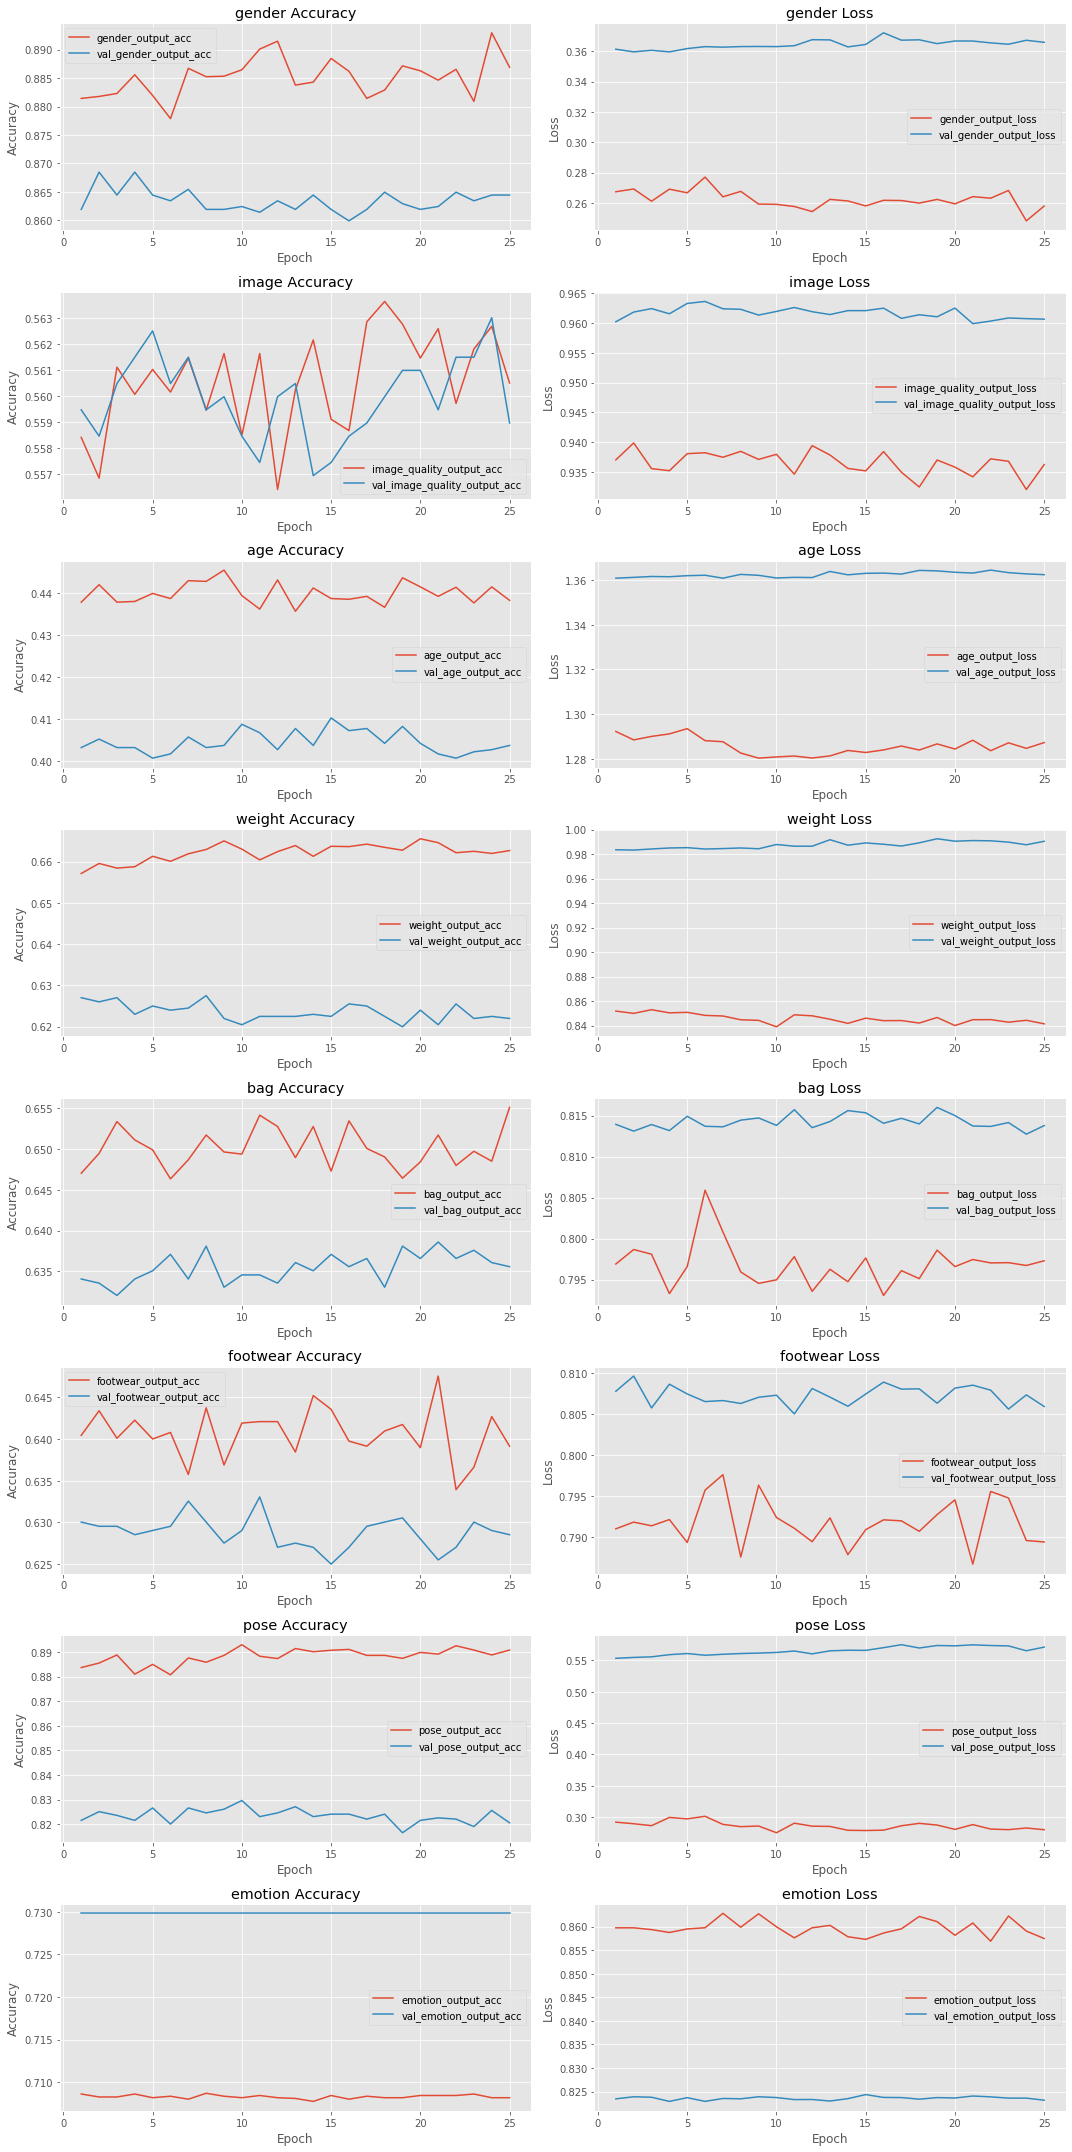

In [0]:
train_n_test(model, lr=1e-4, MODEL_SAVE_PATH=MODEL_PATH, saved_model=True)

## epoch **(100 to 125)**


[INFO] loading model /content/gdrive/My Drive/saved_model/epoch_100.h5 ...
[INFO] old learning rate: 9.999999747378752e-05
[INFO] start from the learning rate: 0.0001
Epoch 1/25
360/360 [==============================] - 114s 316ms/step - loss: 1.5635 - gender_output_loss: 0.2518 - image_quality_output_loss: 0.9353 - age_output_loss: 1.2861 - weight_output_loss: 0.8424 - bag_output_loss: 0.7897 - footwear_output_loss: 0.7900 - pose_output_loss: 0.2746 - emotion_output_loss: 0.8563 - gender_output_acc: 0.8916 - image_quality_output_acc: 0.5592 - age_output_acc: 0.4416 - weight_output_acc: 0.6634 - bag_output_acc: 0.6566 - footwear_output_acc: 0.6426 - pose_output_acc: 0.8918 - emotion_output_acc: 0.7088 - val_loss: 1.9502 - val_gender_output_loss: 0.3654 - val_image_quality_output_loss: 0.9608 - val_age_output_loss: 1.3616 - val_weight_output_loss: 0.9906 - val_bag_output_loss: 0.8140 - val_footwear_output_loss: 0.8088 - val_pose_output_loss: 0.5747 - val_emotion_output_loss: 0.8236 - v

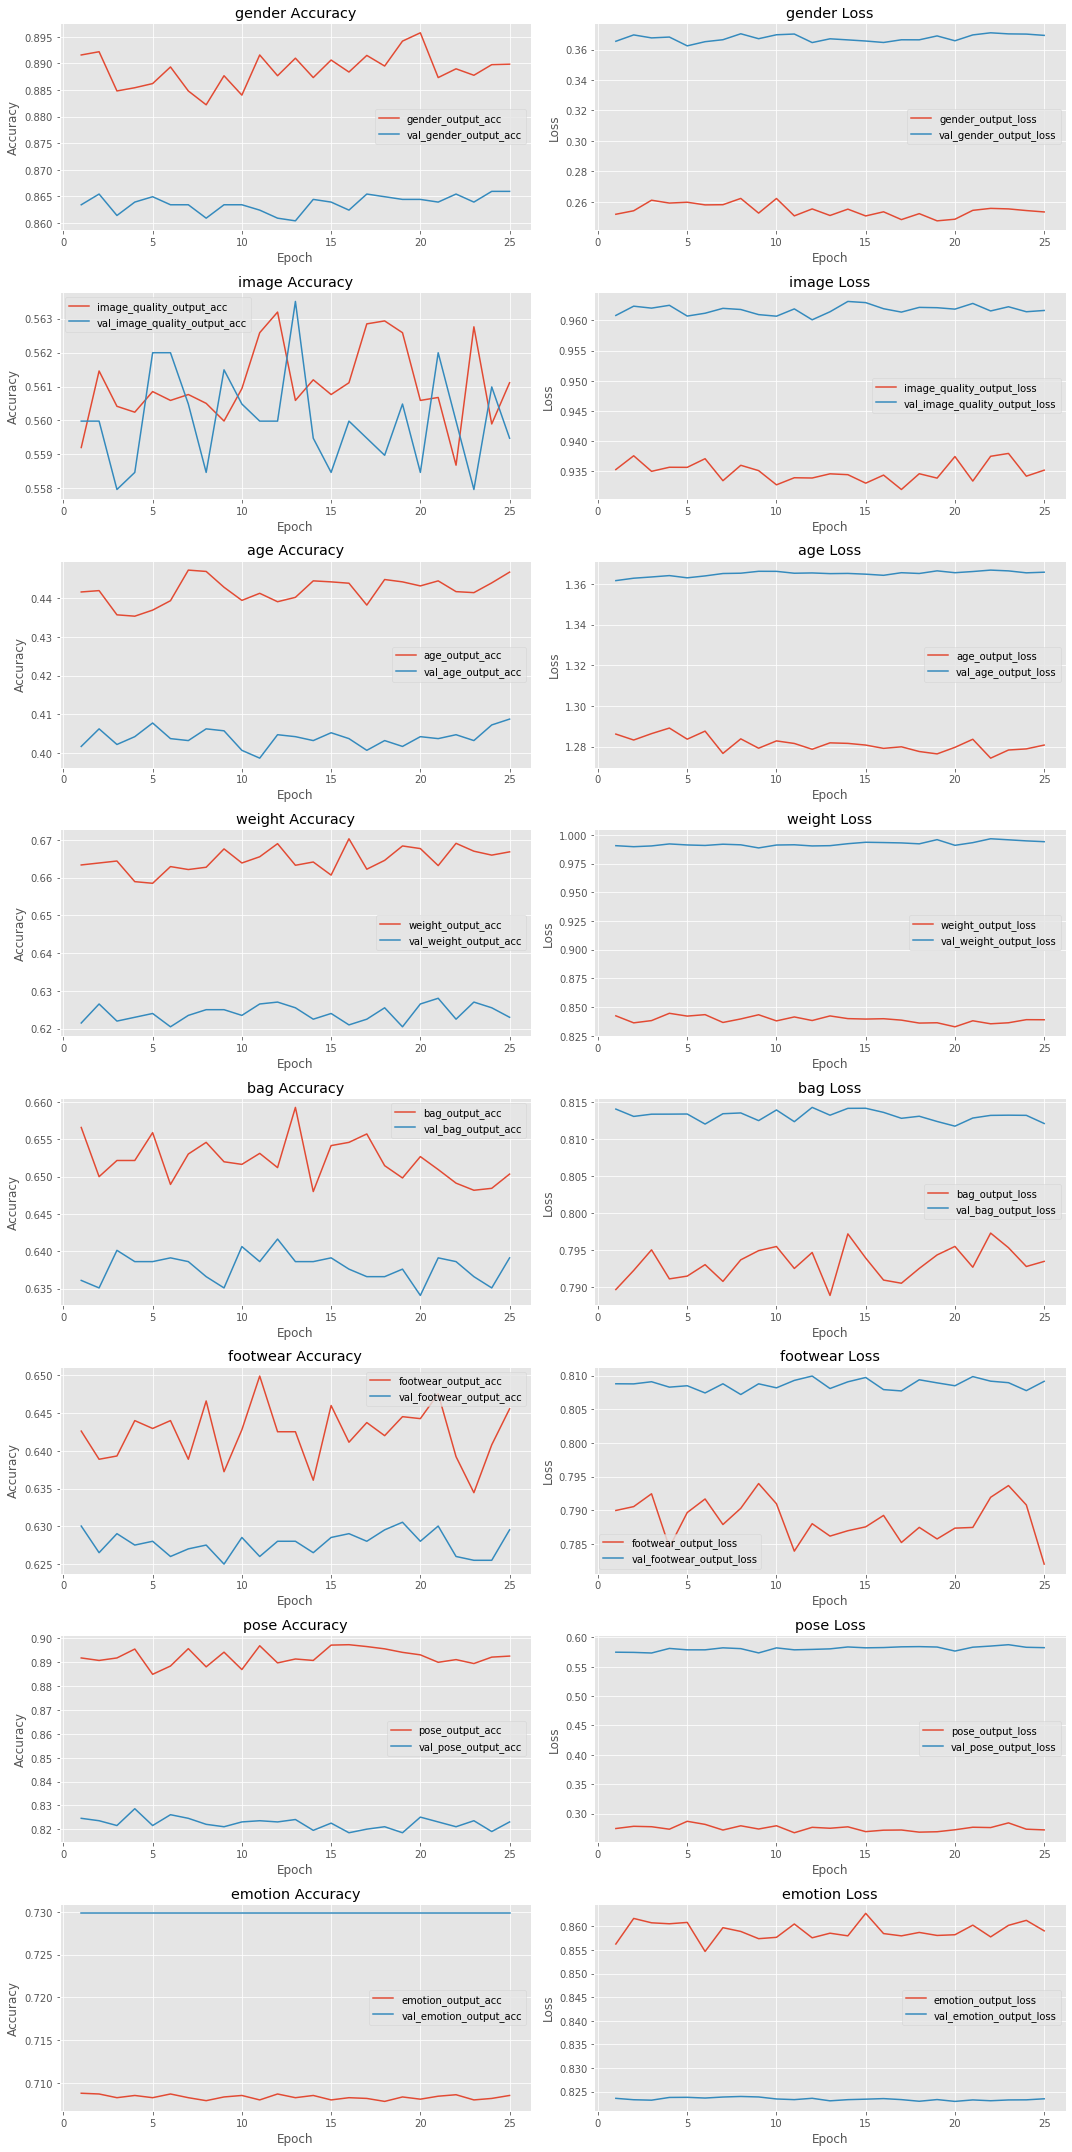

In [0]:
train_n_test(model, lr=1e-4, MODEL_SAVE_PATH=MODEL_PATH, saved_model=True)

## epoch **(125 to 150)**

[INFO] loading model /content/gdrive/My Drive/saved_model/epoch_125.h5 ...
[INFO] old learning rate: 9.999999747378752e-05
[INFO] start from the learning rate: 1e-05
Epoch 1/25
359/360 [============================>.] - ETA: 0s - loss: 1.5573 - gender_output_loss: 0.2548 - image_quality_output_loss: 0.9328 - age_output_loss: 1.2791 - weight_output_loss: 0.8390 - bag_output_loss: 0.7935 - footwear_output_loss: 0.7866 - pose_output_loss: 0.2695 - emotion_output_loss: 0.8575 - gender_output_acc: 0.8926 - image_quality_output_acc: 0.5589 - age_output_acc: 0.4424 - weight_output_acc: 0.6650 - bag_output_acc: 0.6488 - footwear_output_acc: 0.6464 - pose_output_acc: 0.8952 - emotion_output_acc: 0.7085

360/360 [==============================] - 117s 325ms/step - loss: 1.5576 - gender_output_loss: 0.2547 - image_quality_output_loss: 0.9332 - age_output_loss: 1.2790 - weight_output_loss: 0.8386 - bag_output_loss: 0.7936 - footwear_output_loss: 0.7866 - pose_output_loss: 0.2700 - emotion_output_l

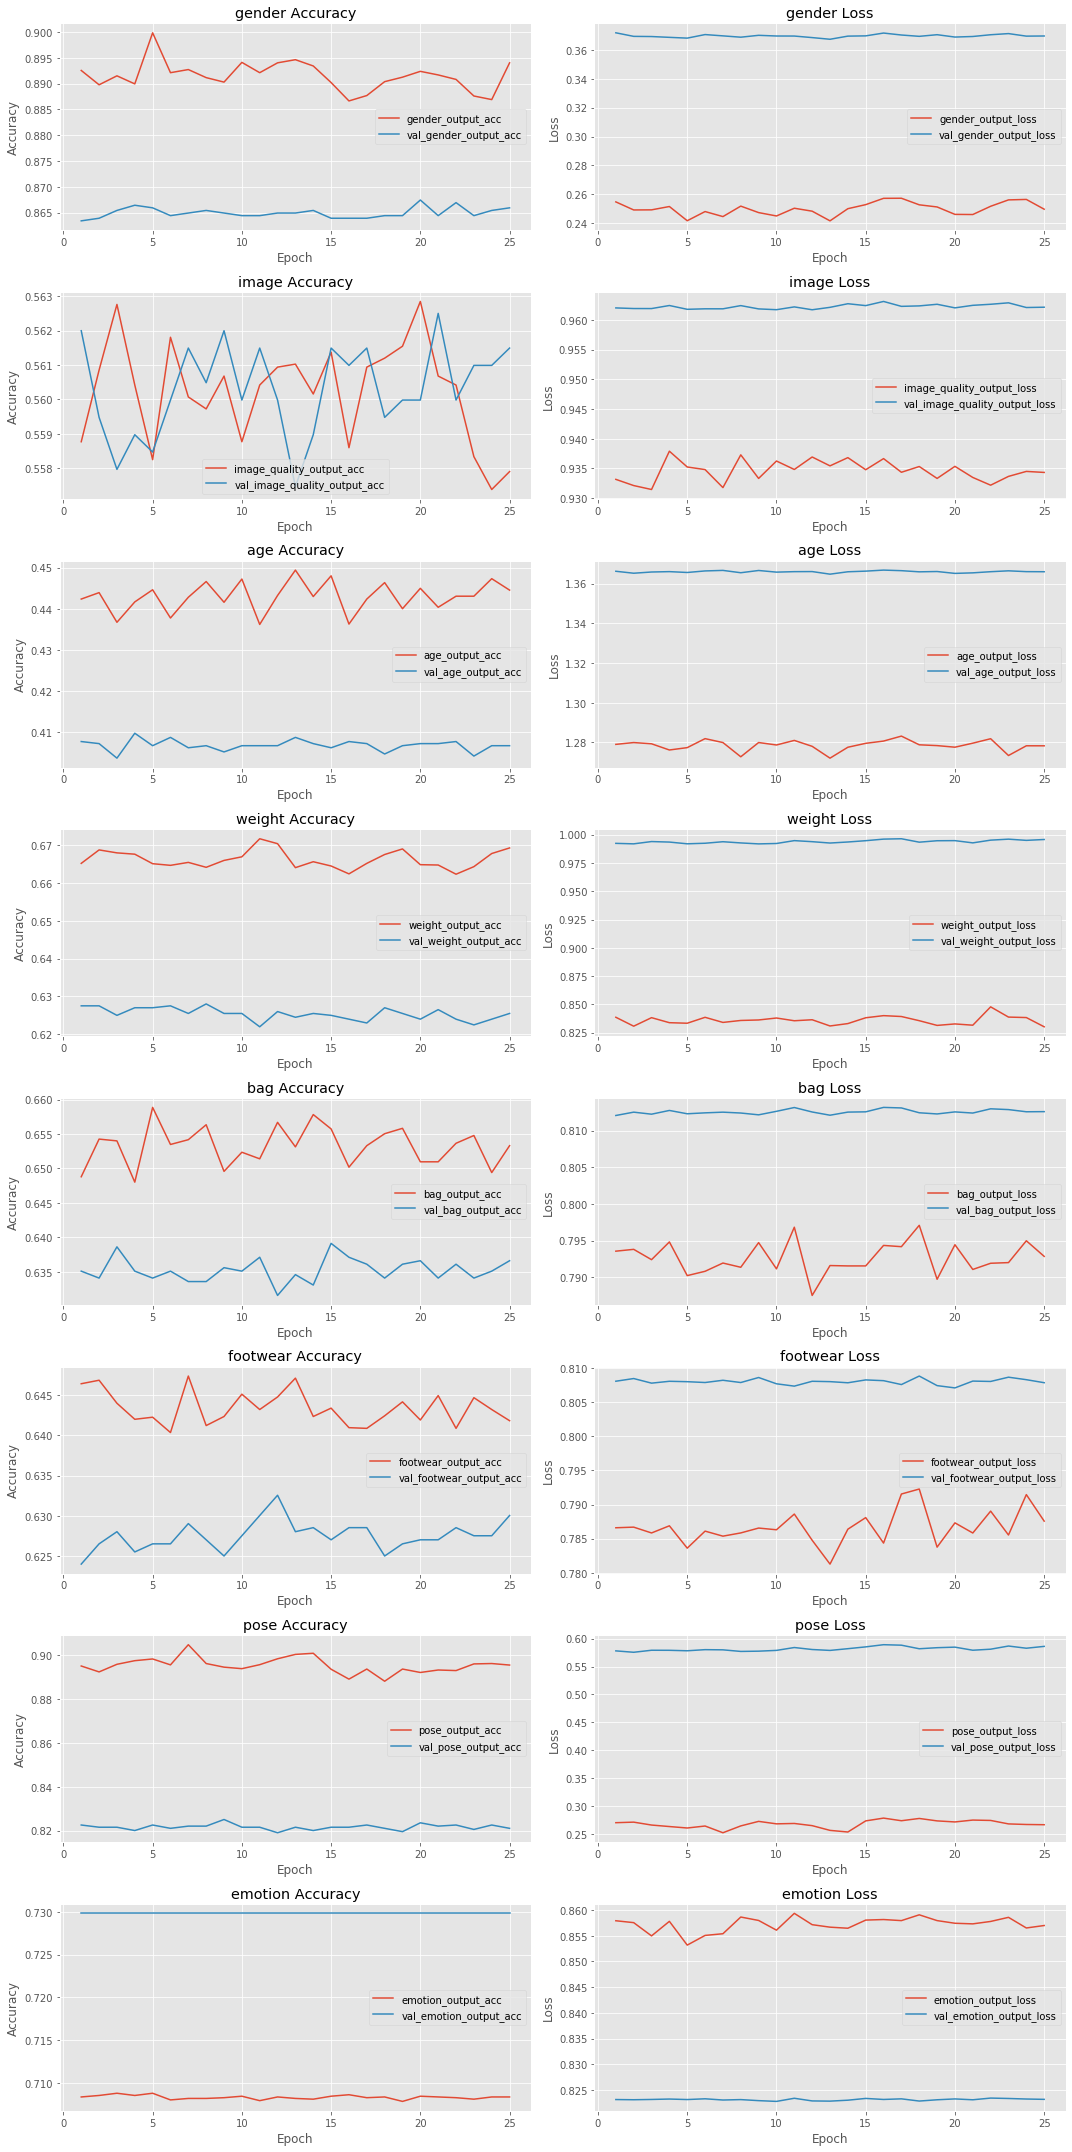

In [0]:
train_n_test(model, lr=1e-5, MODEL_SAVE_PATH=MODEL_PATH, saved_model=True)